## Load & Extract

#### Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#### Read in data

In [4]:
df = pd.read_csv('yahoo.csv')

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-12-27,20.299999,20.299999,20.299999,20.299999,20.299999,2940000
1,1950-12-28,20.379999,20.379999,20.379999,20.379999,20.379999,3560000
2,1950-12-29,20.430000,20.430000,20.430000,20.430000,20.430000,3440000
3,1951-01-02,20.770000,20.770000,20.770000,20.770000,20.770000,3030000
4,1951-01-03,20.690001,20.690001,20.690001,20.690001,20.690001,3370000


In [6]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
17611,2020-12-18,3722.389893,3726.699951,3685.840088,3709.409912,3709.409912,7068340000
17612,2020-12-21,3684.280029,3702.899902,3636.479980,3694.919922,3694.919922,4732160000
17613,2020-12-22,3698.080078,3698.260010,3676.159912,3687.260010,3687.260010,4023940000
17614,2020-12-23,3693.419922,3711.239990,3689.280029,3690.010010,3690.010010,3772630000
17615,2020-12-24,3694.030029,3703.820068,3689.320068,3703.060059,3703.060059,1885090000


In [7]:
df.shape

(17616, 7)

#### Train Test Split

In [8]:
test_size=int(df.shape[0]*0.3)

In [9]:
df_train = df.iloc[:, 1:2].values[:-test_size]

In [10]:
df_train.shape

(12332, 1)

In [11]:
df_test = df.iloc[:, 1:2].values[-test_size:]

In [12]:
df_test.shape

(5284, 1)

## EDA

#### Plot

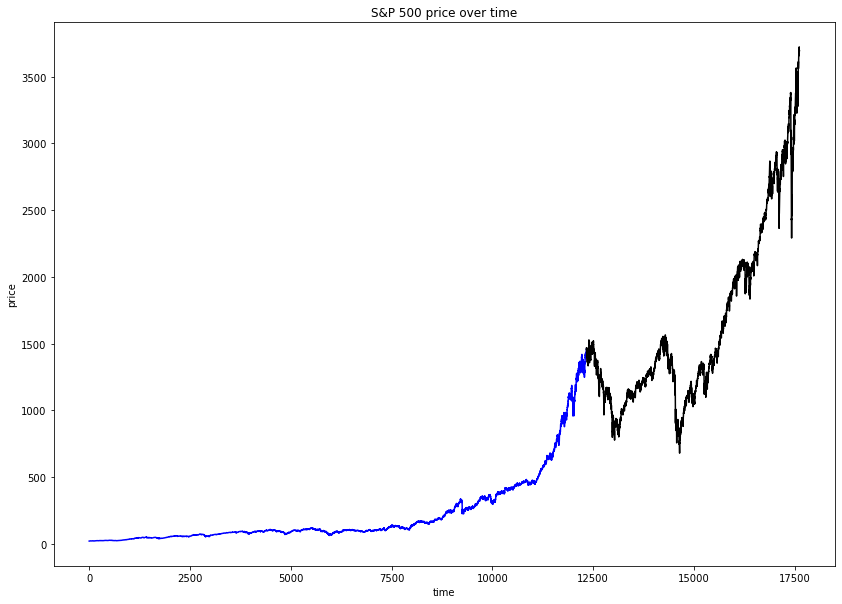

In [13]:
plt.figure(figsize=(14,10))
plt.plot(list(range(0, len(df_train))), df_train, c="blue", label="train")
plt.plot(list(range(len(df_train), len(df_train)+len(df_test))),df_test, c="black", label="test")
plt.title("S&P 500 price over time")
plt.xlabel("time")
plt.ylabel("price")
plt.show()

#### Autocorrelation

In [14]:
from statsmodels.graphics.tsaplots import plot_acf

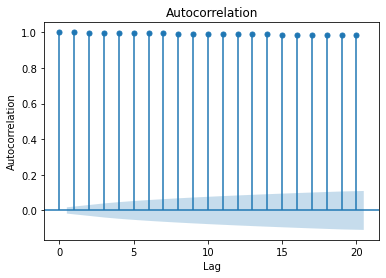

In [15]:
plot_acf(df_train, lags=20)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

#### Partial Autocorrelation

In [16]:
from statsmodels.graphics.tsaplots import plot_pacf

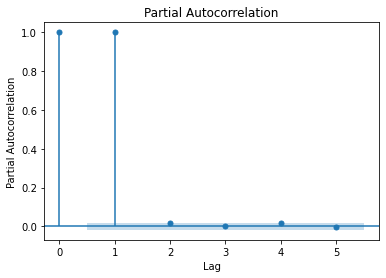

In [17]:
plot_pacf(df_train, lags=5)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.show()

#### AR Model

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
from statsmodels.tsa.ar_model import AR

Lag: 1
Coefficients: [-0.04376651  1.00074028]


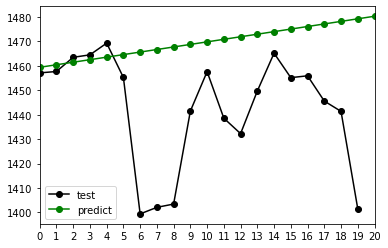

In [20]:
model = AR(df_train)
model_fit = model.fit(maxlag=1)

print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(df_train), end=len(df_train)+20)

plt.figure()
plt.plot(df_test[:20], c="black", label="test", marker='o')
plt.plot(predictions, c="green", label="predict", marker='o')
plt.xlim([0, 20])
plt.xticks(np.arange(0, 21))
plt.legend()
plt.show();

#### MA Model

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

Coefficients: [4.13429830e-02 2.54093151e+00 3.66832085e+00 3.45823382e+00
 2.12718811e+00 7.07399248e-01 2.77928180e+02]


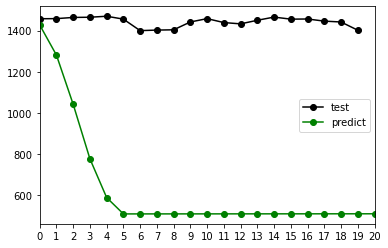

In [22]:
model = SARIMAX(df_train, order=(0, 0, 5), trend="t") 
model_fit = model.fit()

print('Coefficients: %s' % model_fit.params)

predictions = model_fit.predict(start=len(df_train), end=len(df_train)+20)

plt.figure()
plt.plot(df_test[:20], c="black", label="test", marker='o')
plt.plot(predictions, c="green", label="predict", marker='o')
plt.xlim([0, 20])
plt.xticks(np.arange(0, 21))
plt.legend()
plt.show();

## Data Preprocessing

#### Scaling

In [23]:
sc = MinMaxScaler()
df_train_scaled = sc.fit_transform(df_train)
df_test_scaled = sc.transform(df_test)

In [24]:
df_train_scaled.shape

(12332, 1)

In [25]:
df_test_scaled.shape

(5284, 1)

#### Feature/Target

In [26]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


In [27]:
X_train, y_train = split_sequence(df_train_scaled, 60)

In [28]:
X_train.shape

(12272, 60, 1)

In [29]:
y_train.shape

(12272, 1)

In [30]:
X_test, y_test = split_sequence(df_test_scaled,60)

In [31]:
X_test.shape

(5224, 60, 1)

In [32]:
y_test.shape

(5224, 1)

## Stacked LSTM

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Bidirectional
from sklearn.metrics import r2_score

In [187]:
model = Sequential()

model.add(LSTM(50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(50))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 100, verbose = 1)

Epoch 1/100
307/307 [==============================] - 54s 126ms/step - loss: 6.4319e-04 - val_loss: 0.0053
Epoch 2/100
307/307 [==============================] - 37s 121ms/step - loss: 6.4755e-05 - val_loss: 0.0018
Epoch 3/100
307/307 [==============================] - 30s 96ms/step - loss: 5.2040e-05 - val_loss: 0.0020
Epoch 4/100
307/307 [==============================] - 31s 102ms/step - loss: 4.8817e-05 - val_loss: 0.0018
Epoch 5/100
307/307 [==============================] - 29s 96ms/step - loss: 4.2829e-05 - val_loss: 0.0012
Epoch 6/100
307/307 [==============================] - 29s 94ms/step - loss: 4.1142e-05 - val_loss: 0.0021
Epoch 7/100
307/307 [==============================] - 28s 91ms/step - loss: 4.6897e-05 - val_loss: 0.0032
Epoch 8/100
307/307 [==============================] - 28s 91ms/step - loss: 3.6520e-05 - val_loss: 0.0052
Epoch 9/100
307/307 [==============================] - 29s 95ms/step - loss: 3.7036e-05 - val_loss: 0.0020
Epoch 10/100
307/307 [============

307/307 [==============================] - 29s 95ms/step - loss: 2.7964e-05 - val_loss: 0.0793
Epoch 77/100
307/307 [==============================] - 30s 97ms/step - loss: 2.4435e-05 - val_loss: 0.0810
Epoch 78/100
307/307 [==============================] - 31s 102ms/step - loss: 2.3575e-05 - val_loss: 0.0827
Epoch 79/100
307/307 [==============================] - 32s 105ms/step - loss: 2.1590e-05 - val_loss: 0.0752
Epoch 80/100
307/307 [==============================] - 31s 102ms/step - loss: 2.4021e-05 - val_loss: 0.0799
Epoch 81/100
307/307 [==============================] - 28s 90ms/step - loss: 1.9998e-05 - val_loss: 0.0794
Epoch 82/100
307/307 [==============================] - 28s 91ms/step - loss: 2.3393e-05 - val_loss: 0.0773
Epoch 83/100
307/307 [==============================] - 29s 94ms/step - loss: 2.3996e-05 - val_loss: 0.0802
Epoch 84/100
307/307 [==============================] - 28s 91ms/step - loss: 2.6228e-05 - val_loss: 0.0839
Epoch 85/100
307/307 [================

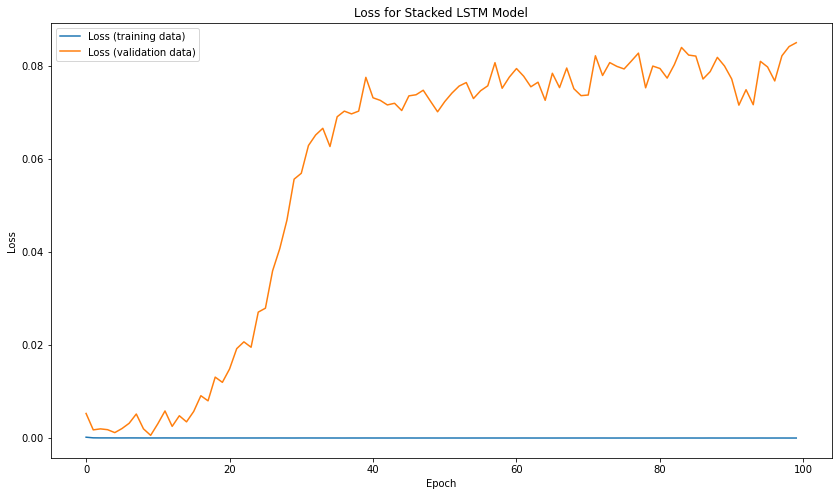

In [188]:
plt.figure(figsize=(14,8))
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Stacked LSTM Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=2)
plt.show()

In [189]:
y_pred = model.predict(X_test, verbose=1)

164/164 [==============================] - 9s 32ms/step


In [190]:
y_pred = sc.inverse_transform(y_pred)

In [191]:
y_true = sc.inverse_transform(y_test)

In [192]:
r2_score(y_true,y_pred)

-3.9141023381319835

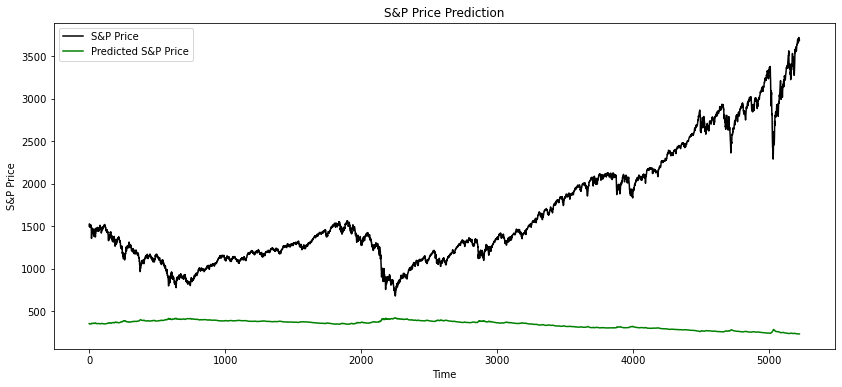

In [193]:
plt.figure(figsize=(14,6))
plt.plot(y_true, color = 'black', label = 'S&P Price')
plt.plot(y_pred, color = 'green', label = 'Predicted S&P Price')
plt.title('S&P Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P Price')
plt.legend()
plt.show()

## Bidirectional LSTM

In [89]:
model = Sequential()

model.add(Bidirectional(LSTM(50, input_shape = (X_train.shape[1], 1))))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 100, verbose = 1)

Epoch 1/100
307/307 [==============================] - 15s 31ms/step - loss: 2.5096e-04 - val_loss: 4.6517e-04
Epoch 2/100
307/307 [==============================] - 13s 41ms/step - loss: 9.6506e-06 - val_loss: 2.5260e-04
Epoch 3/100
307/307 [==============================] - 10s 34ms/step - loss: 7.4387e-06 - val_loss: 4.0921e-04
Epoch 4/100
307/307 [==============================] - 12s 40ms/step - loss: 5.4802e-06 - val_loss: 9.9033e-04
Epoch 5/100
307/307 [==============================] - 11s 35ms/step - loss: 4.8615e-06 - val_loss: 4.0772e-04
Epoch 6/100
307/307 [==============================] - 18s 59ms/step - loss: 4.5149e-06 - val_loss: 5.2434e-04
Epoch 7/100
307/307 [==============================] - 16s 53ms/step - loss: 5.2092e-06 - val_loss: 2.0246e-04
Epoch 8/100
307/307 [==============================] - 12s 38ms/step - loss: 3.1904e-06 - val_loss: 6.2459e-04
Epoch 9/100
307/307 [==============================] - 26s 86ms/step - loss: 3.3659e-06 - val_loss: 1.0966e-04
E

307/307 [==============================] - 14s 46ms/step - loss: 1.2522e-06 - val_loss: 3.1634e-05
Epoch 75/100
307/307 [==============================] - 14s 46ms/step - loss: 1.1178e-06 - val_loss: 5.1091e-05
Epoch 76/100
307/307 [==============================] - 14s 44ms/step - loss: 9.9812e-07 - val_loss: 3.1191e-05
Epoch 77/100
307/307 [==============================] - 14s 47ms/step - loss: 9.5924e-07 - val_loss: 5.1704e-05
Epoch 78/100
307/307 [==============================] - 11s 35ms/step - loss: 1.0450e-06 - val_loss: 3.2201e-05
Epoch 79/100
307/307 [==============================] - 11s 37ms/step - loss: 1.0551e-06 - val_loss: 3.2625e-05
Epoch 80/100
307/307 [==============================] - 12s 39ms/step - loss: 1.3825e-06 - val_loss: 3.8081e-05
Epoch 81/100
307/307 [==============================] - 20s 64ms/step - loss: 1.0079e-06 - val_loss: 3.2380e-05
Epoch 82/100
307/307 [==============================] - 13s 41ms/step - loss: 9.1929e-07 - val_loss: 6.1707e-05
Epoch

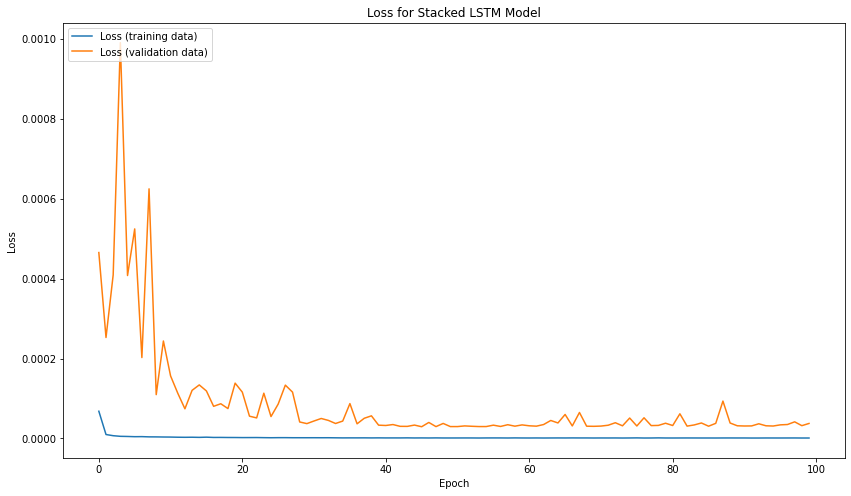

In [98]:
plt.figure(figsize=(14,8))
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Stacked LSTM Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=2)
plt.show()

In [99]:
y_pred = model.predict(X_test, verbose=1)

164/164 [==============================] - 2s 13ms/step


In [100]:
y_pred = sc.inverse_transform(y_pred)

In [101]:
y_true = sc.inverse_transform(y_test)

In [102]:
r2_score(y_true,y_pred)

0.994021695642909

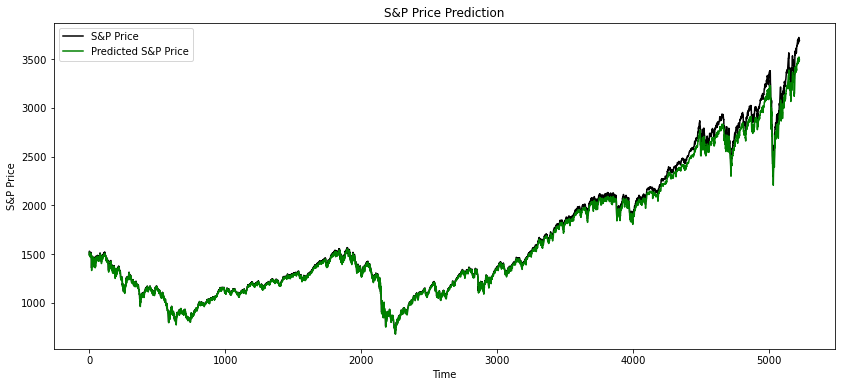

In [103]:
plt.figure(figsize=(14,6))
plt.plot(y_true, color = 'black', label = 'S&P Price')
plt.plot(y_pred, color = 'green', label = 'Predicted S&P Price')
plt.title('S&P Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P Price')
plt.legend()
plt.show()

## Single Layer LSTM 

In [194]:
model = Sequential()

model.add(LSTM(50, input_shape = (X_train.shape[1], 1)))

model.add(Dense(1))

model.compile(optimizer = 'adam', loss = 'mse')

history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 100, verbose = 1)

Epoch 1/100
307/307 [==============================] - 17s 39ms/step - loss: 5.6462e-04 - val_loss: 2.1363e-04
Epoch 2/100
307/307 [==============================] - 7s 24ms/step - loss: 4.6271e-06 - val_loss: 9.3155e-04
Epoch 3/100
307/307 [==============================] - 7s 22ms/step - loss: 4.1484e-06 - val_loss: 1.7678e-04
Epoch 4/100
307/307 [==============================] - 6s 21ms/step - loss: 5.4138e-06 - val_loss: 3.5214e-04
Epoch 5/100
307/307 [==============================] - 6s 21ms/step - loss: 4.4519e-06 - val_loss: 1.7280e-04
Epoch 6/100
307/307 [==============================] - 8s 27ms/step - loss: 3.1387e-06 - val_loss: 4.3878e-04
Epoch 7/100
307/307 [==============================] - 7s 23ms/step - loss: 3.6556e-06 - val_loss: 1.3838e-04
Epoch 8/100
307/307 [==============================] - 6s 21ms/step - loss: 3.2129e-06 - val_loss: 2.2471e-04
Epoch 9/100
307/307 [==============================] - 7s 22ms/step - loss: 3.6614e-06 - val_loss: 9.8022e-05
Epoch 10/

Epoch 75/100
307/307 [==============================] - 7s 22ms/step - loss: 1.7211e-06 - val_loss: 3.4448e-05
Epoch 76/100
307/307 [==============================] - 7s 23ms/step - loss: 1.2375e-06 - val_loss: 4.5118e-05
Epoch 77/100
307/307 [==============================] - 7s 22ms/step - loss: 1.1803e-06 - val_loss: 3.2704e-05
Epoch 78/100
307/307 [==============================] - 7s 21ms/step - loss: 1.3420e-06 - val_loss: 3.3014e-05
Epoch 79/100
307/307 [==============================] - 7s 22ms/step - loss: 1.3063e-06 - val_loss: 5.5376e-05
Epoch 80/100
307/307 [==============================] - 6s 21ms/step - loss: 1.2009e-06 - val_loss: 3.8480e-05
Epoch 81/100
307/307 [==============================] - 7s 22ms/step - loss: 9.1159e-07 - val_loss: 6.1919e-05
Epoch 82/100
307/307 [==============================] - 7s 23ms/step - loss: 1.1042e-06 - val_loss: 4.7795e-05
Epoch 83/100
307/307 [==============================] - 7s 23ms/step - loss: 1.3906e-06 - val_loss: 4.2705e-05
E

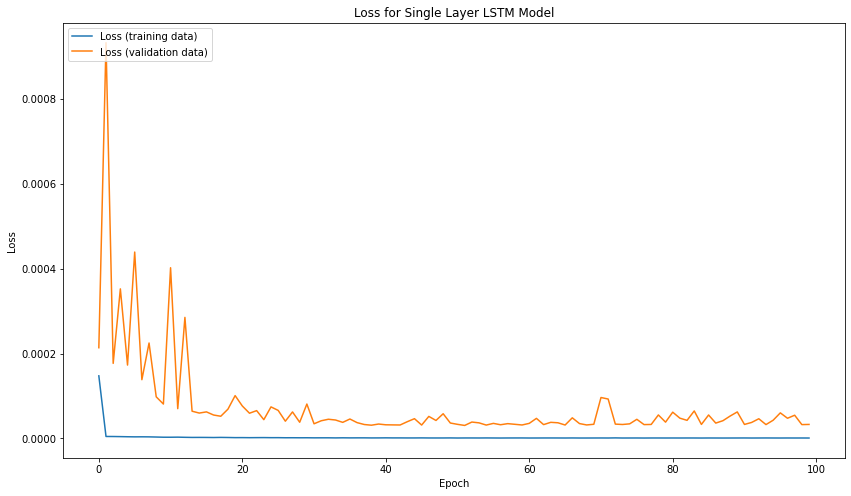

In [195]:
plt.figure(figsize=(14,8))
plt.plot(history.history['loss'], label='Loss (training data)')
plt.plot(history.history['val_loss'], label='Loss (validation data)')
plt.title('Loss for Single Layer LSTM Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc=2)
plt.show()

In [196]:
y_pred = model.predict(X_test, verbose=1)

164/164 [==============================] - 2s 9ms/step


In [197]:
y_pred = sc.inverse_transform(y_pred)

In [198]:
y_true = sc.inverse_transform(y_test)

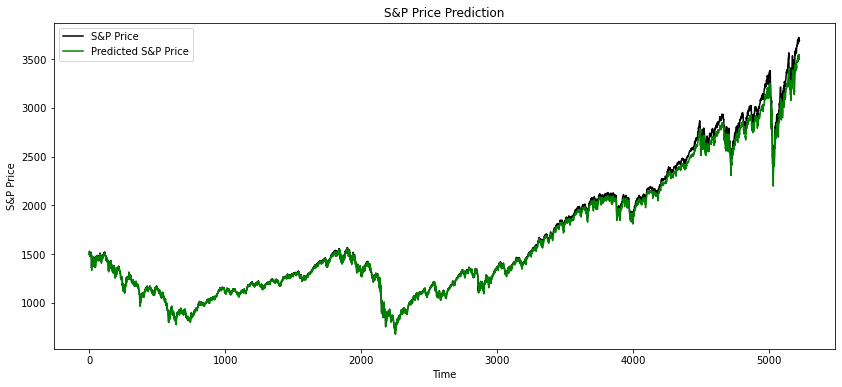

In [199]:
plt.figure(figsize=(14,6))
plt.plot(y_true, color = 'black', label = 'S&P Price')
plt.plot(y_pred, color = 'green', label = 'Predicted S&P Price')
plt.title('S&P Price Prediction')
plt.xlabel('Time')
plt.ylabel('S&P Price')
plt.legend()
plt.show()

In [200]:
r2_score(y_true,y_pred)

0.9952583203811488

## Dashboard

In [111]:
import plotly.express as px 
import plotly.graph_objects as go

In [201]:
df_pred = pd.DataFrame(y_pred,columns=['pred'])
df_pred['true']=y_true
df_pred['time']=df_pred.index

df_pred

,pred,true,time
0,1493.465576,1500.640015,0
1,1489.986694,1527.349976,1
2,1523.146118,1527.459961,2
3,1515.113647,1523.859985,3
4,1512.714355,1507.729980,4
...,...,...,...
5219,3540.218262,3722.389893,5219
5220,3547.321045,3684.280029,5220
5221,3500.273682,3698.080078,5221
5222,3532.429688,3693.419922,5222


In [202]:
df_pred.to_csv('pred1.csv')

## Prediction (1 day)

In [203]:
dff = pd.read_csv('010821.csv')
dff.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
246,2021-01-04,3764.610107,3769.989990,3662.709961,3700.649902,3700.649902,5006680000
247,2021-01-05,3698.020020,3737.830078,3695.070068,3726.860107,3726.860107,4582620000
248,2021-01-06,3712.199951,3783.040039,3705.340088,3748.139893,3748.139893,6049970000
249,2021-01-07,3764.709961,3811.550049,3764.709961,3803.790039,3803.790039,5080870000
250,2021-01-08,3815.050049,3826.689941,3783.600098,3824.679932,3824.679932,4764180000


In [204]:
dff = dff.iloc[:, 1:2].values

In [205]:
dff = sc.transform(dff)

In [206]:
dff = dff[-60:].reshape(1,60,1)

In [207]:
pred_scaled = model.predict(dff,verbose=1)

1/1 [==============================] - 0s 33ms/step


In [208]:
pred = sc.inverse_transform(pred_scaled)

In [209]:
print('Monday January 11th, 2020: ', pred)

Monday January 11th, 2020:  [[3637.2927]]
